In [1]:
import torch
import torch.nn as nn
from typing import List, Optional
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

In [2]:
class FCNN(nn.Module):
    def __init__(self, input_dimension=1, output_dimension=3,
                 n_hidden_layers=3, neurons=8,):
        super(FCNN, self).__init__()
        
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.neurons = neurons
        self.n_hidden_layers = n_hidden_layers
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
    
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

In [3]:
def autograd(y: torch.Tensor, x: List[torch.Tensor]) -> List[torch.Tensor]:
    grad_outputs: List[Optional[torch.Tensor]] = [torch.ones_like(y, device=y.device)]

    grad = torch.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=grad_outputs,
        create_graph=True,
        allow_unused=True,
    )
    
    grad = [g if g is not None else torch.zeros_like(xx) for xx, g in zip(x, grad)]
    
    return grad

In [4]:
g = 9.8
v_max = 25
a_min = -2.0*g
a_max = 1.4*g
mu = 1.6
M = 800.

def u_init(s:torch.Tensor):
    return torch.hstack([12.5*torch.cos(s*torch.pi), 12.5*torch.sin(s*torch.pi), .7*torch.ones_like(s)])

In [5]:
s = torch.linspace(0, 1, 1001).reshape(-1, 1)

In [6]:
torch.manual_seed = 0
u_nn = FCNN()
opt = optim.Adam(u_nn.parameters(), lr=1e-3)

In [7]:
for epoch in range(10000):
    opt.zero_grad()
    u = u_nn(s)
    loss = torch.linalg.vector_norm(u_nn(s) - u_init(s), ord=1)
    print(f"\r [{epoch/10000}], loss:{np.round(loss.detach().numpy(), 2)}", end='')
    loss.backward()
    opt.step()

 [0.9999], loss:39.250000610351565

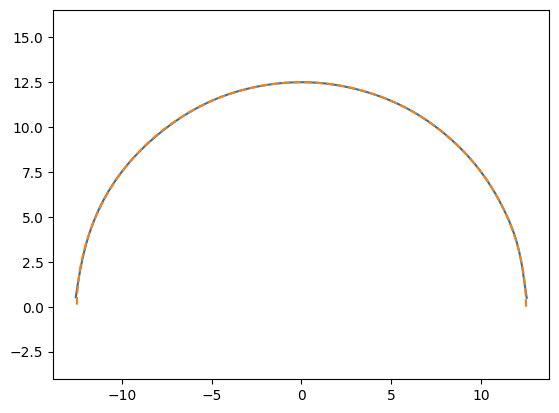

In [8]:
s.requires_grad = True
x = u_nn(s)[:, 0]
y = u_nn(s)[:, 1]
x_true = u_init(s)[:, 0]
y_true = u_init(s)[:, 1]
s.requires_grad = False

with torch.no_grad():
    plt.axis('equal')
    plt.plot(x, y)
    plt.plot(x_true, y_true, '--')

In [9]:
def compute_losses(u_nn, s):
    s.requires_grad = True
    u = u_nn(s)
    x, y, v = u[:, 0].reshape(-1, 1), u[:, 1].reshape(-1, 1),u[:, 2].reshape(-1, 1)
    dx = autograd(x, s)[0]
    dy = autograd(y, s)[0]
    dv = autograd(v, s)[0]
    ddx = autograd(dx, s)[0]
    ddy = autograd(dx, s)[0]

    ds = torch.sqrt(dx**2 + dy**2)

    loss = [0.001 * torch.sum(ds/(v*v_max))]

    loss += [torch.linalg.norm(torch.max(v - 1.0, torch.zeros_like(v)))]
    loss += [torch.linalg.norm(torch.max(-v, torch.zeros_like(v)))]

    loss += [torch.linalg.norm(torch.max((v_max**2)*v*dv/ds - a_max, torch.zeros_like(v)))]
    loss += [torch.linalg.norm(torch.max((v_max**2)*v*(-1)*dv/ds + a_min, torch.zeros_like(v)))]
    
    loss += [torch.linalg.norm(torch.max((v*v_max)**2 * (torch.abs(ddx*dy - ddy*dx)/(ds**3)) - (mu*g)*torch.ones_like(v), torch.zeros_like(v)))]

    loss += [torch.linalg.norm(torch.max(-(x**2+y**2) + 100 , torch.zeros_like(x)))]
    loss += [torch.linalg.norm(torch.max((x**2+y**2) - 225 , torch.zeros_like(x)))]

    loss += [max(torch.linalg.norm(u_nn(s[0,])[0] - 12.5) - 0.2, 0.)]
    loss += [max(torch.linalg.norm(u_nn(s[0,])[1]) - 0.2, 0.)]
    loss += [max(torch.linalg.norm(u_nn(s[-1,])[0] + 12.5) - 0.2, 0.)]
    loss += [max(torch.linalg.norm(u_nn(s[-1,])[1])- 0.2, 0.)]

    loss += [torch.abs(u_nn(torch.tensor([[0.]]))[:, 2] - .7)]
    return sum(loss), loss

In [10]:
epochs = 25000
lr = 1e-3
opt = optim.Adam(u_nn.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[10000], gamma=0.1)

In [11]:
history = []
for epoch in range(epochs):
    def closure():
        opt.zero_grad()
        loss, _ = compute_losses(u_nn, s)
        print(f"\r [{np.round(epoch/epochs, 2)}], loss:{np.round(loss.detach().numpy(), 5)}", end='')
        loss.backward()
        history.append(loss.detach().numpy()[0])
        return loss
    opt.step(closure)
    scheduler.step()

 [1.0], loss:[1.4468]]]]

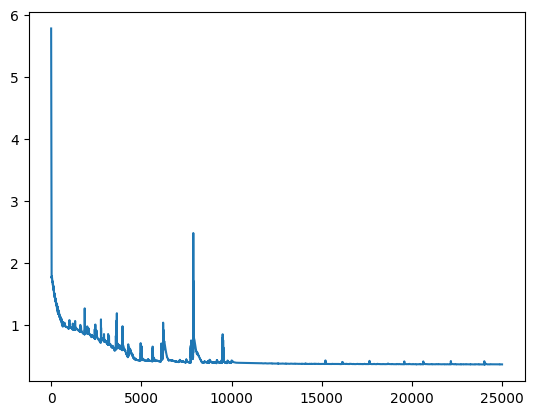

In [12]:
plt.plot(np.log(history))
plt.show()

In [13]:
s.requires_grad = True
u = u_nn(s)
x, y, v = u[:, 0].reshape(-1, 1), u[:, 1].reshape(-1, 1),u[:, 2].reshape(-1, 1)
dx = autograd(x, s)[0]
dy = autograd(y, s)[0]
dv = autograd(v, s)[0]
ddx = autograd(dx, s)[0]
ddy = autograd(dx, s)[0]
s.requires_grad = False

ds = torch.sqrt(dx**2 + dy**2)

k = (torch.abs(ddx*dy - ddy*dx)/(ds**3))
aT = (v_max**2)*v*dv/ds
aN = (v*v_max)**2 * (torch.abs(ddx*dy - ddy*dx)/(ds**3))

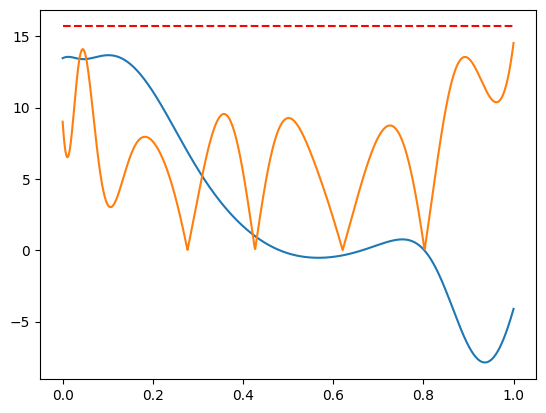

In [14]:
with torch.no_grad():
    plt.plot(s, aT)
    plt.plot(s, aN)
    plt.plot(s, mu*g*np.ones_like(s),'--r')

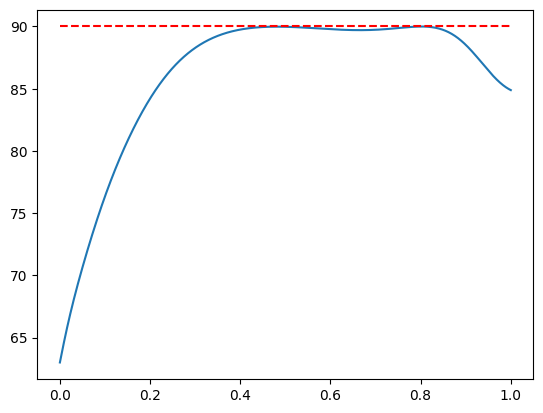

In [15]:
with torch.no_grad():
    plt.plot(s, v*v_max*3.6)
    plt.plot(s, v_max*np.ones_like(s)*3.6,'--r')

In [16]:
def braking_point_index(aT):
    bpi = -1
    for i in range(1, len(aT)):
        if aT[i-1]>=0 and aT[i]<0:
            bpi = i
            break
    return bpi

In [17]:
bpi =  braking_point_index(aT)

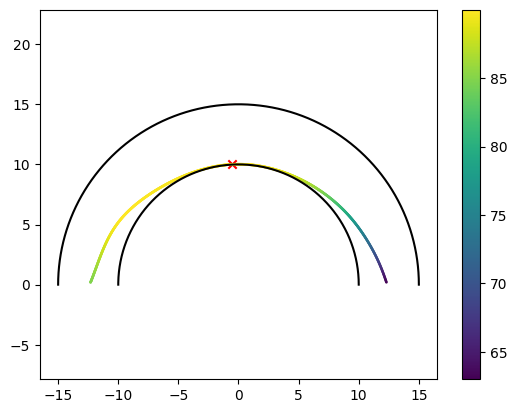

In [18]:
with torch.no_grad():
    plt.axis('equal')
    plt.plot(10*np.cos(np.pi*s), 10*np.sin(np.pi*s), 'black')
    plt.scatter(x[bpi], y[bpi], marker='x', c='r')
    plt.scatter(x, y, c=v*v_max*3.6, s=.8)
    plt.plot(15*np.cos(np.pi*s), 15*np.sin(np.pi*s), 'black')
    plt.colorbar()